## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# %pdb

In [2]:
import glob

import numpy as np
import scipy as sp
import scipy.io
import scipy.signal

import matplotlib.pyplot as plt
import pandas as pd
import pprint


fs = 125  # From the Readme.pdf  (./datasets/troika/Readme.pdf)
acceptable_fs_range = np.array([40, 240]) / 60  # from 40 to 240 in BPM


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of
    the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that
        ref_fls[5] is the
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls


def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability.

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and
            corresponding reference heart rates.
        confidence_est: a numpy array of confidence estimates
        for each pulse rate error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))


def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and
    returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)


def RunPulseRateAlgorithm(data_fl, ref_fl):
    """ The runner of PulseRateAlgorithm

    This function is used unit test.
    The detailed implementation of the algorithm is delegated
    to the `PulseRateAlgorithm` function


    Args:
        data_fl: (str) filepath to a troika .mat file.
        ref_fl: (str) filepath to a reference file like "REF_XX_TYPEXX.mat"

    Returns:
        errors: The absolute error of pulse rate between
                 estimation and reference in bpm.
        condiden: The metrics introduced to estimate
                  the confidence of the result bpm.
    """

    errors, confidence, _ = PulseRateAlgorithm(data_fl, ref_fl)

    # Return per-estimate mean absolute error and confidence
    # as a 2-tuple of numpy arrays.

    return errors, confidence


#############################################
# The followings are parts of RunPulseRateAlgorithm function
#############################################

def PulseRateAlgorithm(data_fl, ref_fl, algorithm='largest_peak',
                       est_smooth=True, IS_DEBUG=False):
    """ Estimate Pulse Rate and returns thier errors and confidence

    This is the main part of PulseRateAlgorithm.

    Args:
        data_fl: (str) filepath to a troika .mat file.
        ref_fl: (str) filepath to a reference file like "REF_XX_TYPEXX.mat"
        algorithm: (str) algorithm type. The 'largest_peak'
                    or 'distribution_average' are available.
        est_smooth: (bool) If the parameter set True, smoothing is
                    appied to the estimated frequency
        IS_DEBUG: If True is set, this returns debug
                  information as a return value.

    Returns:
        errors: The absolute error of pulse rate between estimation
                and reference in bpm.
        condiden: The metrics introduced to estimate
                  the confidence of the result bpm.
        debug_info: Returns debug info when the IS_DEBUG value is True.
    """

    debug_info = {}

    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)

    # Compute pulse rate estimates and estimation confidence.

    # read ground truth
    ref_bpms = sp.io.loadmat(ref_fl)["BPM0"].reshape(-1)

    # calc total acceleration
    acc = np.sqrt(accx**2 + accy**2 + accz**2)

    # Apply Bandpass Filter to pgg and acc
    ppg_band = BandpassFilter(ppg, acceptable_fs_range, fs)
    acc_band = BandpassFilter(acc, acceptable_fs_range, fs)

    # Calculate FFT with the 8 sec time window and
    # stride 2 sec stride (6 sec overlap)
    ppg_specs, ppg_freqs = Spectrums(ppg_band, fs, NFFT=8*fs, noverlap=6*fs)
    acc_specs, acc_freqs = Spectrums(acc_band, fs, NFFT=8*fs, noverlap=6*fs)

    # Assumes that difference of frequencies is constant.
    freqs = ppg_freqs
    d_freq = freqs[1] - freqs[0]

    # The number of spectrums
    n_specs = ppg_specs.shape[1]

    # Normalize each spectrum
    ppg_specs_nm = [NormalizeByFrequency(
        ppg_specs[:, i], d_freq) for i in range(n_specs)]
    acc_specs_nm = [NormalizeByFrequency(
        acc_specs[:, i], d_freq) for i in range(n_specs)]

    est_bpms = []
    confidences = []

    for i in range(n_specs):
        ppg_spec = ppg_specs_nm[i]
        acc_spec = acc_specs_nm[i]

        if algorithm == 'largest_peak':
            est_bpm, conf = EstimatePulsRateFromLargestPeak(
                ppg_spec, acc_spec, freqs)
        elif algorithm == 'distribution_average':
            est_bpm, conf = EstimatePulsRateFromDistribuionAverage(
                ppg_spec, acc_spec, freqs)
        else:
            raise ValueError(
                "algorithm should be 'largest_peak'" +
                " or 'distribution_average'." +
                f" But got : {algorithm}")

        if est_smooth:
            est_bpm = SmoothResult(est_bpm, est_bpms)

        est_bpms.append(est_bpm)
        confidences.append(conf)

    confidences = np.array(confidences)
    est_bpms = np.array(est_bpms)
    errors = np.abs(ref_bpms - est_bpms)

    if IS_DEBUG:
        debug_info["ppg_specs"] = ppg_specs_nm
        debug_info["acc_specs"] = acc_specs_nm
        debug_info["freqs"] = freqs
        debug_info["est_bpms"] = est_bpms
        debug_info["ref_bpms"] = ref_bpms
        debug_info["errors"] = errors

    return errors, confidences, debug_info


def BandpassFilter(signal, pass_band, fs):
    """Bandpass Filter.

    Args:
        signal: (np.array) The input signal
        pass_band: (tuple) The pass band. Frequency components outside
            the two elements in the tuple will be removed.
        fs: (number) The sampling rate of <signal>

    Returns:
        (np.array) The filtered signal
    """
    b, a = sp.signal.butter(3, pass_band, btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)


def Spectrums(signal, fs, NFFT, noverlap):
    """Calculate spectrum in a given time window width

    Args:
        signal: (np.array) The input signal
        fs: (number) The sampling rate of <signal>
        NFFT: (number) The number used for the FFT block.
        noverlap: (number) The number of sample that overlap with previous block
    Returns:
        spectrums: (2-D np.array) The list of FFT results.
                   Columns are corresnponding to FFT results.
        freqs: (1-D np.array) The frequences calculated
               by given <fs> and <NFFT> values
    """

    n = len(signal)

    # Each block has (NFFT - noverlap) non overlapped samples,
    step = (NFFT - noverlap)
    n_block = (n - NFFT) // step + 1

    specs = []
    for i in range(n_block):
        w = signal[i * step:i*step+NFFT].copy()

        # the `plt.specgram` apply hanning window on each stride windows
        # w *= np.hanning(len(w))

        fft = np.abs(np.fft.rfft(w))
        specs.append(fft)

    specs = np.stack(specs, axis=1)
    freq = np.fft.rfftfreq(NFFT, d=1/fs)
    return specs, freq


def FrequencyFilter(specs, freqs, freq_range):

    min_freq, max_freq = freq_range

    specs[freqs < min_freq] = 0
    specs[freqs > max_freq] = 0

    return specs


def NormalizeByFrequency(spectrum, d_freq):
    """Normalize signal intencity by frequency

    Args:
        spectrum: (np.array) The input spectrum
        d_freq: The difference of the frequency

    Returns:
        normalized_spectrum: The normalized spectrum
    """

    norm = (spectrum * d_freq).sum()
    return spectrum / norm


def EstimatePulsRateFromLargestPeak(ppg_spec, acc_spec, freqs):
    """ Estimate Puls Rate from the ppg spectrum's lagest peak position

    Args:
        ppg_spec: (np.array) The ppg's spectrum
        acc_spec:(np.array) The accelometer's spectrum
        freqs: (np.array) frequency list that corresponds to ppg_spec and acc_spec
    Returns:
        est_bpm: estimated puls rate in BPM
        conf: The confidence metrics
    """
    ppg_peak = SelectByLargest(ppg_spec, acc_spec)
    est_freq = freqs[ppg_peak]

    conf = EstimatePeakIntensity(ppg_spec, freqs, ppg_peak, 2)
    est_bpm = est_freq * 60.0

    return est_bpm, conf


def EstimatePulsRateFromDistribuionAverage(ppg_spec,
                                           acc_spec,
                                           freqs,
                                           penalty=2):
    """ Estimate Puls Rate from the ppg spectrum distribution

    Args:
        ppg_spec: (np.array) The ppg's spectrum
        acc_spec:(np.array) The accelometer's spectrum
        freqs: (np.array) frequency list that corresponds
               to ppg_spec and acc_spec
        penalty: (numeric) strength how suppress the spectrum
                 when the ppg and acc spectrums overlapped.
    Returns:
        est_bpm: estimated puls rate in BPM
        conf: The confidence metrics
    """
    freq_min, freq_max = acceptable_fs_range

    # Define window area to extract meaningful area
    window = (freqs >= freq_min) & (freqs <= freq_max)

    # Penalize the area of large acc values
    weights = ppg_spec / (1.0 + penalty*acc_spec)

    # Use only windowed region
    freqs = freqs[window]
    weights = weights[window]

    # Normalize for the window area
    weights = weights / weights.sum()

    # Calculate mean freqeuncy as a estimated puls rate
    freq_mean = (weights * freqs).sum()

    # Confidence is defined by 1/(1+std) as a approximation
    # of the inverse of standard deviation
    freq_var = (((freqs - freq_mean)**2) * weights).sum()
    freq_stddev = np.sqrt(freq_var / len(freqs))
    conf = 1/(1.0+freq_stddev)

    est_bpm = 60*freq_mean

    return est_bpm, conf


def EstimatePeakIntensity(spectrum, freqs, peak, peak_width):
    """ Calculate intensity of peak

    As a confidency, the intensity of peak is estimated
    by the sum of the spectrum around the peak.

    Args:
        spectrum : (np.array) The ppg's spectrum.
        freqs: (np.array) frequency list that corresponds to spectrum.
        peak_width: (int) the width of frequency space that include intensity.
        The spectrum between `peak-peak_width` and `peak+peak_width` are
        included in the summation
    Returns:
        confidence: (numeric) The ratio between peak intensity
                    and total sum of spectrum.

    """

    n = len(freqs)
    peak_area = np.arange(peak-peak_width, peak+peak_width+1)
    peak_area = peak_area[np.where((peak_area >= 0) & (peak_area < n))[0]]

    return spectrum[peak_area].sum() / spectrum.sum()


def SelectByLargest(ppg_spec, acc_spec):
    """ Returns estimated pulse rate that takes into account
        the effect of acceleration.
    """

    ppg_cands = np.argsort(ppg_spec)[::-1]
    acc_peaks, _ = scipy.signal.find_peaks(acc_spec, height=0.5)

    for pk in ppg_cands[:3]:
        if pk not in acc_peaks:
            return pk

    # if upto the 3d largest position is overlaped with acc,
    # returns the lagest peak
    return ppg_cands[0]


def SmoothResult(cur_est, est_history):
    """ Apply smoothing the estimated pulse rate

    Args:
        cur_est : (numeric) The current estimation before the smoothing.
        est_history: (list) The list of previous result.

    Returns:
        smoothed_estimation: (numeric) The ratio between peak intensity
        and total sum of spectrum.
    """

    if len(est_history) < 3:
        return cur_est
    else:
        return (
            0.4*cur_est + 0.3*est_history[-1] +
            0.2*est_history[-2] +
            0.1*est_history[-3])


## Observation of some results

### 1. Data load and simple overview of the input data

In [3]:
print("acceptable fs range is", acceptable_fs_range)

data_fls, ref_fls = LoadTroikaDataset()

assert(len(data_fls) == len(ref_fls))

print(f"{len(data_fls)} files are found")
pprint.pprint(data_fls[:5])
pprint.pprint(ref_fls[:5])

ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])


df = pd.DataFrame({"ppg": ppg, "accx": accx, "accy": accy, "accz": accz})
print(f"{df.shape[0]} samples are found")
df.head()

acceptable fs range is [ 0.66666667  4.        ]
12 files are found
['./datasets/troika/training_data/DATA_01_TYPE01.mat',
 './datasets/troika/training_data/DATA_02_TYPE02.mat',
 './datasets/troika/training_data/DATA_03_TYPE02.mat',
 './datasets/troika/training_data/DATA_04_TYPE01.mat',
 './datasets/troika/training_data/DATA_04_TYPE02.mat']
['./datasets/troika/training_data/REF_01_TYPE01.mat',
 './datasets/troika/training_data/REF_02_TYPE02.mat',
 './datasets/troika/training_data/REF_03_TYPE02.mat',
 './datasets/troika/training_data/REF_04_TYPE01.mat',
 './datasets/troika/training_data/REF_04_TYPE02.mat']
37937 samples are found


,ppg,accx,accy,accz
0,4.0,-0.0702,0.3432,0.9594
1,6.0,-0.0702,0.3588,0.9438
2,3.0,-0.0546,0.3666,0.9360
3,3.5,-0.0468,0.3666,0.9360
4,0.0,-0.0468,0.3744,0.9126


### 2. Apply algorithm and plot the results

In [4]:
def plot_results(debug_info):
    """ Plot results
    This plot comparison of estimation and ground truth,
    and some snapshot of PPG and ACC spectrums.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(debug_info["est_bpms"], "g.-", label="Estimate")
    plt.plot(debug_info["ref_bpms"], "r.-", label="Reference")
    plt.plot(confidences*100, label="Condidence(relative)")
    plt.legend()
    plt.show()

    ref_bpm = debug_info["ref_bpms"]
    est_bpm = debug_info["est_bpms"]
    ppg_specs = debug_info["ppg_specs"]
    acc_specs = debug_info["acc_specs"]
    freqs = debug_info["freqs"]

    cutoff = 50

    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.flatten()
    fig.suptitle("Bad case")
    for i, f_i in enumerate(np.arange(len(errors))[errors > 30][:6]):
        ax = axes[i]
        ax.set_title(f"At {f_i} th, conf:{confidences[f_i]:.2f}")
        ax.plot(freqs[:cutoff], ppg_specs[f_i][:cutoff], '.-', label="ppg")
        ax.plot(freqs[:cutoff], acc_specs[f_i][:cutoff], '.-', label="acc")
        # plt.plot(freqs[pks], scores, 'g.-')
        ax.plot(ref_bpm[f_i]/60, [1.0], 'rx', ms=10,
                markeredgewidth=2, label="Reference")
        ax.plot(est_bpm[f_i]/60, [1.0], 'gx', ms=10,
                markeredgewidth=2, label="Estimation")
        ax.legend()
    plt.show()

    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.flatten()
    fig.suptitle("Good case")
    for i, f_i in enumerate(np.arange(len(errors))[errors < 10][:6]):
        ax = axes[i]
        ax.set_title(f"At {f_i} th, conf:{confidences[f_i]:.2f}")
        ax.plot(freqs[:cutoff], ppg_specs[f_i][:cutoff], '.-', label="ppg")
        ax.plot(freqs[:cutoff], acc_specs[f_i][:cutoff], '.-', label="acc")
        # plt.plot(freqs[pks], scores, 'g.-')
        ax.plot(ref_bpm[f_i]/60, [1.0], 'rx', ms=10,
                markeredgewidth=2, label="Reference")
        ax.plot(est_bpm[f_i]/60, [1.0], 'gx', ms=10,
                markeredgewidth=2, label="Estimation")
        ax.legend()

    plt.show()

In [5]:
# Apply algorithm for each input data

acceptable_fs_range = np.array([40, 240]) / 60

error_means_no_smooth = []
for i_th in range(len(data_fls)):
    est_smooth = False
    algorithm = "largest_peak"  # or "distribution_average"
    errors, confidences, debug_info = PulseRateAlgorithm(
        data_fls[i_th],
        ref_fls[i_th], algorithm=algorithm,
        est_smooth=est_smooth, IS_DEBUG=True)
    error_mean = np.mean(errors)
    print(f"{i_th} th  bpm error: {error_mean:0.2f}")
    error_means_no_smooth.append(error_mean)

0 th  bpm error: 27.10
1 th  bpm error: 21.16
2 th  bpm error: 9.59
3 th  bpm error: 10.50
4 th  bpm error: 16.72
5 th  bpm error: 17.03
6 th  bpm error: 32.33
7 th  bpm error: 26.62
8 th  bpm error: 22.43
9 th  bpm error: 44.69
10 th  bpm error: 29.28
11 th  bpm error: 51.48


From the above results. the errors vary from to

2 th


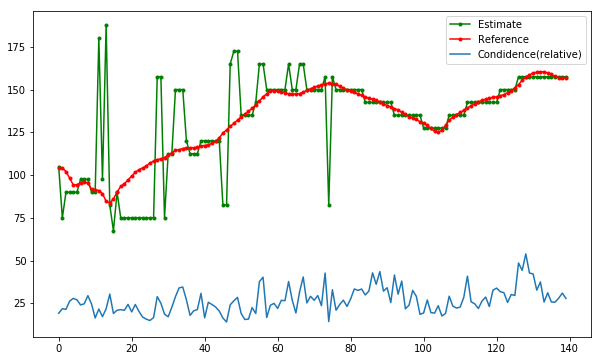

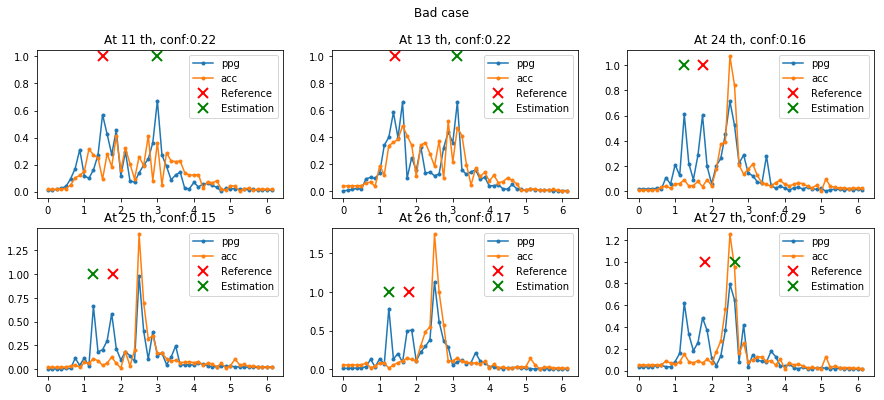

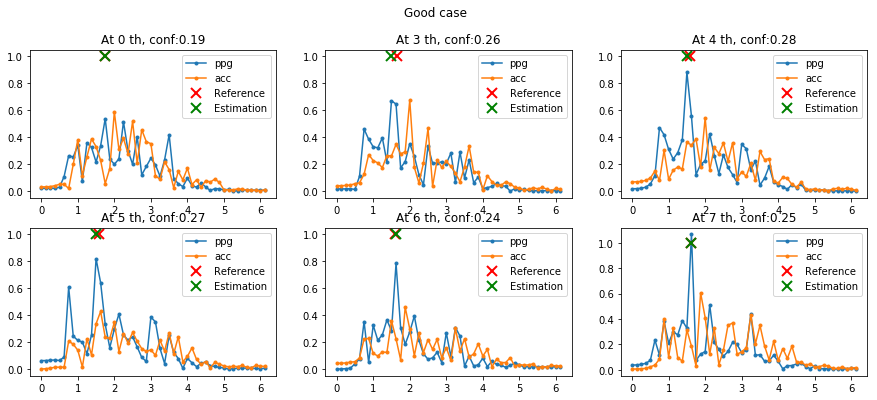

11 th


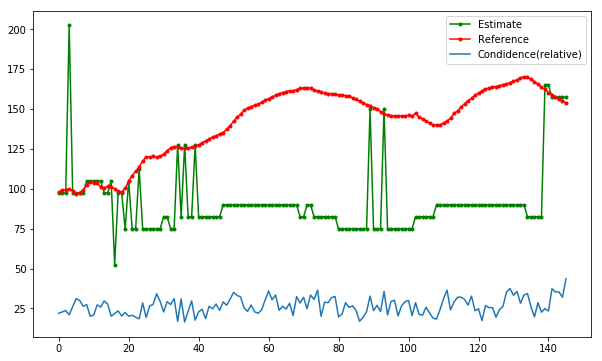

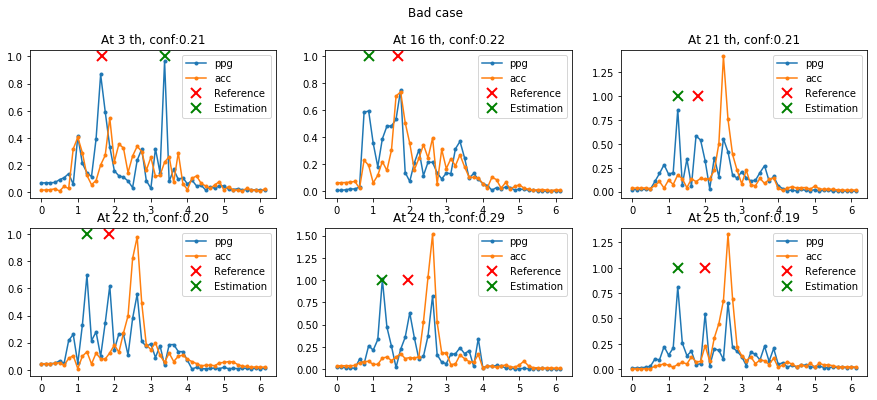

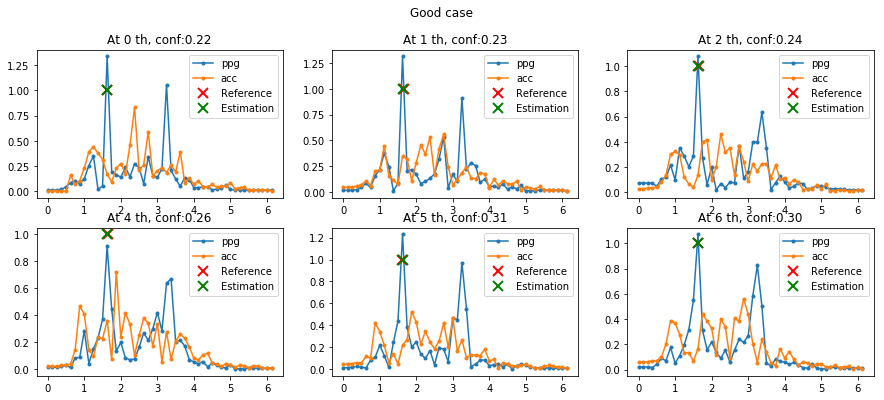

In [6]:
# Select two files, good case(2th) and bad case(11th) and plot the details.
for i_th in [2, 11]:
    print(f"{i_th} th")
    errors, confidences, debug_info = PulseRateAlgorithm(
        data_fls[i_th], ref_fls[i_th], algorithm=algorithm,
        est_smooth=est_smooth, IS_DEBUG=True)
    plot_results(debug_info)


### 3. Effect of smoothing for the results

The estimate is discretized while the ground truth has smooth. In order to mitigate the error originated such a discretized behavior, introduce the smoothing in the algorithm. The results are shown in the following cells

In [7]:
acceptable_fs_range = np.array([40, 240]) / 60
error_means_smooth = []
for i_th in range(len(data_fls)):
    est_smooth = True  # Apply smoothing
    algorithm = "largest_peak"  # or "distribution_average"
    errors, confidences, debug_info = PulseRateAlgorithm(
        data_fls[i_th],
        ref_fls[i_th], algorithm=algorithm,
        est_smooth=est_smooth, IS_DEBUG=True)
    error_mean = np.mean(errors)
    print(f"{i_th} th  bpm error: {error_mean:0.2f}")
    error_means_smooth.append(error_mean)

0 th  bpm error: 20.74
1 th  bpm error: 15.37
2 th  bpm error: 6.31
3 th  bpm error: 8.43
4 th  bpm error: 13.59
5 th  bpm error: 15.37
6 th  bpm error: 30.46
7 th  bpm error: 24.46
8 th  bpm error: 18.07
9 th  bpm error: 43.84
10 th  bpm error: 25.04
11 th  bpm error: 51.77


### 4. Effect of modification of bandpass range


In [8]:
error_means_smooth_narrow_band = []
acceptable_fs_range = np.array([85, 180]) / 60
for i_th in range(len(data_fls)):
    est_smooth = True
    algorithm = "largest_peak"  # or "distribution_average"
    errors, confidences, debug_info = PulseRateAlgorithm(
        data_fls[i_th], ref_fls[i_th], algorithm=algorithm,
        est_smooth=est_smooth, IS_DEBUG=True)
    error_mean = np.mean(errors)
    print(f"{i_th} th  bpm error: {error_mean:0.2f}")
    error_means_smooth_narrow_band.append(error_mean)

0 th  bpm error: 26.60
1 th  bpm error: 13.72
2 th  bpm error: 6.12
3 th  bpm error: 21.08
4 th  bpm error: 9.59
5 th  bpm error: 6.71
6 th  bpm error: 10.87
7 th  bpm error: 3.26
8 th  bpm error: 14.48
9 th  bpm error: 30.86
10 th  bpm error: 20.55
11 th  bpm error: 20.19


### 5. Mean value of Distribution

As a different approach of heart rate estimation, I used a mean value of the PPG spectrum as a pulse rate estimation.


In [9]:
error_means_dist_average = []
acceptable_fs_range = np.array([40, 240]) / 60
for i_th in range(len(data_fls)):
    est_smooth = True
    algorithm = "distribution_average"
    errors, confidences, debug_info = PulseRateAlgorithm(
        data_fls[i_th], ref_fls[i_th], algorithm=algorithm,
        est_smooth=est_smooth, IS_DEBUG=True)
    error_mean = np.mean(errors)
    print(f"{i_th} th  bpm error: {error_mean:0.2f}")
    error_means_dist_average.append(error_mean)


0 th  bpm error: 22.78
1 th  bpm error: 14.41
2 th  bpm error: 14.95
3 th  bpm error: 33.77
4 th  bpm error: 20.01
5 th  bpm error: 16.90
6 th  bpm error: 18.92
7 th  bpm error: 20.34
8 th  bpm error: 15.07
9 th  bpm error: 28.60
10 th  bpm error: 18.78
11 th  bpm error: 29.62


### 6. Comparison between different algorithm

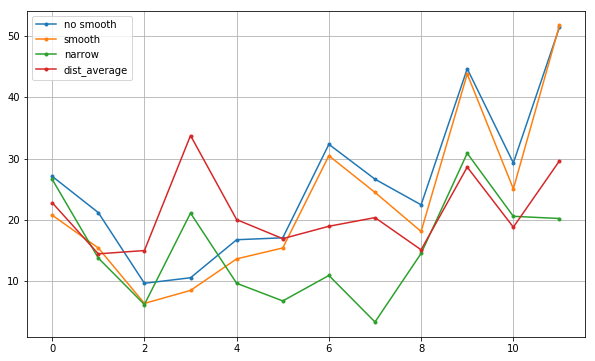

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(error_means_no_smooth, '.-',
         label="no smooth")
plt.plot(error_means_smooth,
         '.-', label="smooth")
plt.plot(error_means_smooth_narrow_band,
         '.-', label="narrow")
plt.plot(error_means_dist_average,
         '.-', label="dist_average")
plt.grid()
plt.legend()


In [11]:
print("no_smooth:", np.mean(error_means_no_smooth))
print("smooth:", np.mean(error_means_smooth))
print("narrow_band:", np.mean(error_means_smooth_narrow_band))
print("dist_average:", np.mean(error_means_dist_average))

no_smooth: 25.7443052125
smooth: 22.7875786607
narrow_band: 15.3367795029
dist_average: 21.1786099912


In [12]:
acceptable_fs_range = np.array([85, 180]) / 60
Evaluate()

14.110046728558556

### 7. Puls rate distribution

([<matplotlib.axis.XTick at 0x7f1eed42b400>,
 <a list of 13 Text xticklabel objects>)

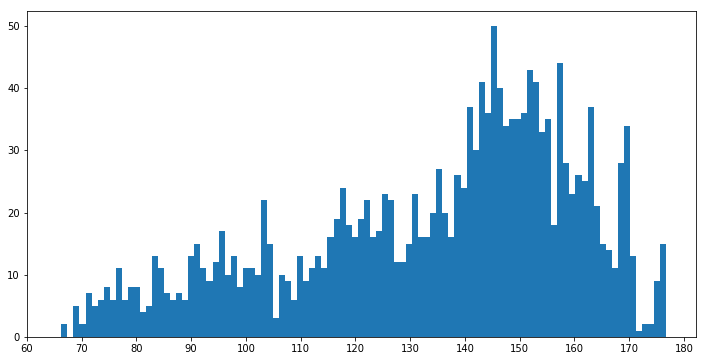

In [13]:
all_refs = []
for i_th in range(len(data_fls)):
    ref_bpm = sp.io.loadmat(ref_fls[i_th])["BPM0"].reshape(-1)
    all_refs.append(ref_bpm)

all_refs = np.concatenate(all_refs)
plt.figure(figsize=(12, 6))
plt.hist(all_refs, bins=100)
plt.xticks(np.arange(60, 190, 10))

In the training data, the most heart rates distribute in the range 70 - 180.

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

### Code Description
This code calculates the hear pulse rate and its confidence metrics from the PPG and accelerometer signals.
You can calculate the estimation errors and confidence value from the `RunPulseRateAlgorithm` function.
If you give the file paths of signals and ground truth, the function calculates the heart rate and its confidence.

The outline of the algorithm consist of the following steps:

1. Load data of a single file by using `LoadTroikaDataFile` function.
2. Load reference data as a ground truth puls rate by using `sp.io.loadmat` function.
3. Apply bandpass filter function `BandpassFilter` to PPG and Accelometor signals.
4. Calculate the spectrum of the signals for each time window in the function `Spectrums`. The window setting is the same as the setting of reference data, window size is 8 sec with sliding by 2 sec.
5. Normalize the spectrum intensity in the function `NormalizeByFrequency`.
6. Estimate PPG's pulse rate from their spectrum peak in the function `EstimatePulsRateFromLargestPeak`.
6. In the `EstimatePulsRateFromLargestPeak`, the `SelectByLargets` function is used to find puls rate.
7. In the `EstimatePulsRateFromLargestPeak`, the confidence is calculated by using `EstimatePeakIntencity` function.
8. In the `SmoothResult` function, modify the estimation `est_bpm` by using previous result `est_bpms` to suppress the strong fluctuation. 

### Data Description

The **Troika**[1] dataset is used to calculate the pulse rate estimation. The dataset contains two types of files. The first is the file that contains the PPG and three-axis acceleration signals recorded from the sensor fitted on the wrist of subjects.
The second is the heart rate that calculated from the ECG signals measured simultaneously from the same subjects.
Here, the PGG and acceleration signals are used to estimate the subjects' heart rate. And estimate the performance by comparing the estimation and the ground truth puls rate.

The followings are basic information of the dataset:

- The signals are sampled at 125Hz.
- Each file contains 5min length data.
- The ground truth heart rates are calculated every 8 second time windows with 6 second overlap.
- Each data have signals of multiple activity. "rest", running on a treadmill in 6 km/h, 8km/h, 12km/h and 15km/h.
In the training phase, the 11 data file are used. The unit test executed with the unknow hold out test data.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015, DOI: 10.1109/TBME.2014.2359372

### Algorithm Description
In this algorithm, the pulse rate is estimated from the PPG signal frequency.
Since the PPG signals are affected by the acceleration of the wrist, the acceleration signals are also taken into account.
Here, I use total acceleration ($\sqrt(accx^2 + accy^2 + accz^2)$) because it is reasonable to think that the influence of the acceleration on the PPG (blood flow) should be independent of the orientation.

I tried two approaches to obtain estimation and confidence.

1. Select the largest PPG spectrum that does not overwrap with acceleration peaks. (`largest_peak`)
2. Assume that the PPG spectrum is a probability distribution and use the mean of the distribution as an estimation. The effect of acceleration is taken into account by suppressing the spectrum if there is overlap with acceleration spectrum. (`distribution_average`)

Note, the approach of `largest_peak` is used as a final result.

####  largest_peak
In this approach, I sort the PPG spectrum and select the largest spectrum's frequency as a candidate of the pulse rate and compare the corresponding frequency with the acceleration spectrum peak positions (frequency). If the frequency is contained by the acceleration peaks, the frequency is rejected, and the next largest PPG spectrum's frequency is picked out. If the third largest PPG frequency is rejected, the algorithm assumes that the heart rate and acceleration coincide and returns the largest frequency as a result.

#### distribution_average
In this approach, I calculate the average of PPG spectrum as a estimated puls rate. In order to take into account the effect of acceleration, the PPG spectrum is modified by the acceleration spectrum
$$p = \frac{p_{\rm{ppg}}}{ (1 + \alpha p_{\rm{acc}})},$$
where $\alpha$ is a hyper parameter that control the effect of acceleration effect, and $p_{\rm{ppg}}, p_{\rm{acc}}$ are PPG and acceleration spectrum, respectively.
The result $p$ is normalized so that the summation should be 1 ($=\sum_f p(f)$).
The pulse rate estimation is obtained from 

$$\bar{f} = \sum_f f  p(f).$$

The confidence $c$ is defined by the reciprocal of standard deviation with additional value (+1) that is introduced to avoid division by zero (`"confidence" = 1/(1 + "std of PPG spectrum")`).

#### smoothing
In each case, The estimate is discretized while the ground truth has smooth. In order to mitigate the error originated such a discretized behavior, I applied the smoothing in the algorithm. The smoothing is implemented as a time series average of the last three estimation results.
For the i-th raw estimation `est_i`, the smoothed i-th result (`smooth_est_i`) is calculated from the last 3 history:

    smooth_est_i = w_0 * est_i + w_1*smooth_est_(i-1) + w_2 * smooth_est_(i-2) + w_3 * smooth_est_(i-3)

where each `w_i` is weight parameter.

#### Caveat and Common failur

The algorithm basically assumes that the largest frequency peak corresponds to heart rate.
Although it takes into account the effect of accelerometer, other factors that can affect the PPG signals are not considered.
For example, the effect of the sun light or the displacement of the devises.
When a non-heart pulse is detected by the PPG sensor, the algorithm misidentifies such signals as a heart beat and returns the wrong results.

### Algorithm Performance

I executed the algorithm to the given training data and investigated the errors.
As I described above, I examined different approaches and compared the results.

1. largest_peak approach without smoothing
2. largest_peak approach with smoothing
3. distribution_average approach with smoothing
4. Narrowing the acceptable BPM range

The results are shown in this notebook.

I used the mean of errors as metrics. The mean is calculated for each data file.
For simplicity, I did not take into account the effect of confidence.
The result varies a lot, depending on the files (6 - 50 BPM).
A typical reason for the bad estimation is because of the existence of the multiple peaks in the PPG spectrum.
Since the algorithm thinks the largest PPG spectrum peak as the heart pulse rate, it is difficult to avoid such a misidentification.

In some cases,  such a misidentified peak appears at a lower frequency, like 80 BPM.
From the observation of the heart rate of ground truth, The proportion of the heart rate sample around 80 BPM looks small.
(The distribution is plotted in this notebook in "7. Puls rate distribution" section)
When I deliberately narrow the acceptable frequency from 60-240 BPM to 85-180 BPM, the peaks that cause misidentification can be eliminated. The approach of "narrowing the acceptable BPM range" is the case where I modified the range to 85-180 BPM.
The results are certainly improved and. But this approach may overfit to the specific data that have a false peak in the lower side.
**Note, for the final algorithm that is applied to test data, I used original range 60-240 BPM.**

Although the algorithm has some hyperparameter, in the project, I did not perform any systematic parameter optimization like cross-validation.
The algorithm based on some basic knowlage of heart rate, PPG sensor and accelerometer property. 


-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 